# Buiding Vision Transformer on CIFAR 10 from scratch

## Overview

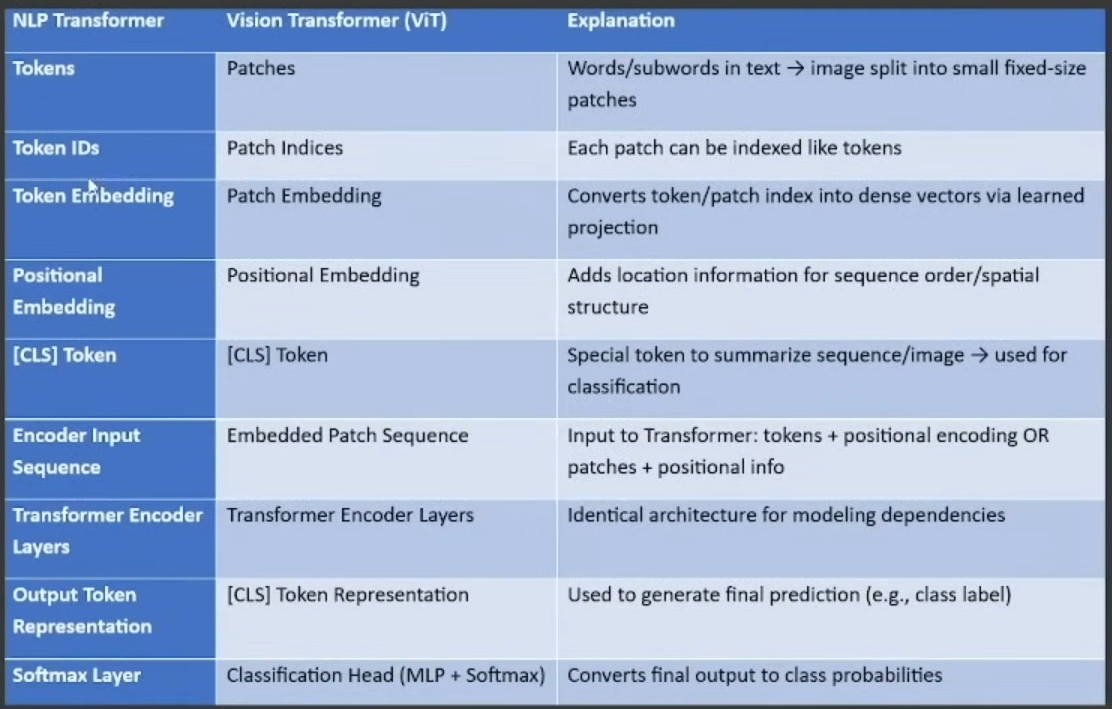

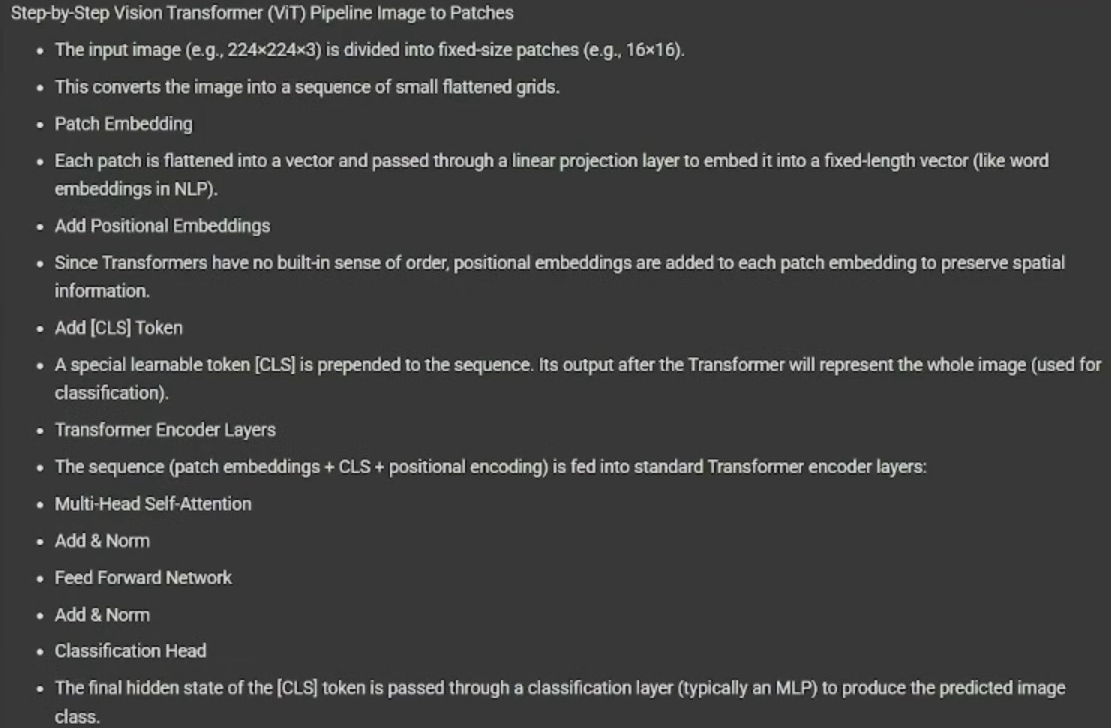

## Importing required libraries

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import random
import matplotlib.pyplot as plt

## Setting device agnostic code

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

## Setting hyperparams

In [18]:
batch_size = 128
epochs = 10
learning_rate = 3e-4
patch_size = 4 # segments 
num_classes = 10
image_size = 32
channels = 3
embed_dim = 256
num_heads = 8    # for multi head attention
depth = 6   # means 6 transformer blocks
mlp_dim = 512    # multilinear perceptron layers
drop_rate = .1


## Define Image transformations 

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5), (.5)),    # helps the model converge faster and helps to make the numerical computations stable
])

## Getting datasets

In [20]:
train_dataset = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('data', train=False, download=True, transform=transform)

In [21]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [22]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

## Converting datasets into dataloaders

In [23]:
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
print(f"DataLoader: {train_dl, test_dl}")
print(f"Length of train_dl: {len(train_dl)} batches of {batch_size}...")
print(f"Length of test_dl: {len(test_dl)} batches of {batch_size}...")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x74fbb2730d70>, <torch.utils.data.dataloader.DataLoader object at 0x74fab6ec7c50>)
Length of train_dl: 391 batches of 128...
Length of test_dl: 79 batches of 128...


## Building Vision Transformer model from scratch

In [25]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)    # projection layer
        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))
    
    def forward(self, x: torch.Tensor):
        B = x.size(0)  # batch size
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)

        # Сворачиваем пространственные размерности в одну ось
        x = x.flatten(2)  # (B, embed_dim, num_patches) → flatten(2) = flatten height and width
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim) → меняем местами channels и patches

        # Расширяем cls_token для всего батча
        cls_token = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)

        # Добавляем cls_token в начало
        x = torch.cat((cls_token, x), dim=1)  # (B, 1 + num_patches, embed_dim)

        # Добавляем позиционные эмбеддинги
        x = x + self.pos_embed  # broadcasting работает: (1, 1+N, E) + (B, 1+N, E)

        return x

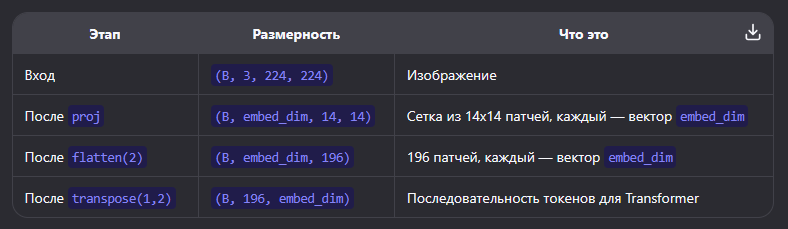

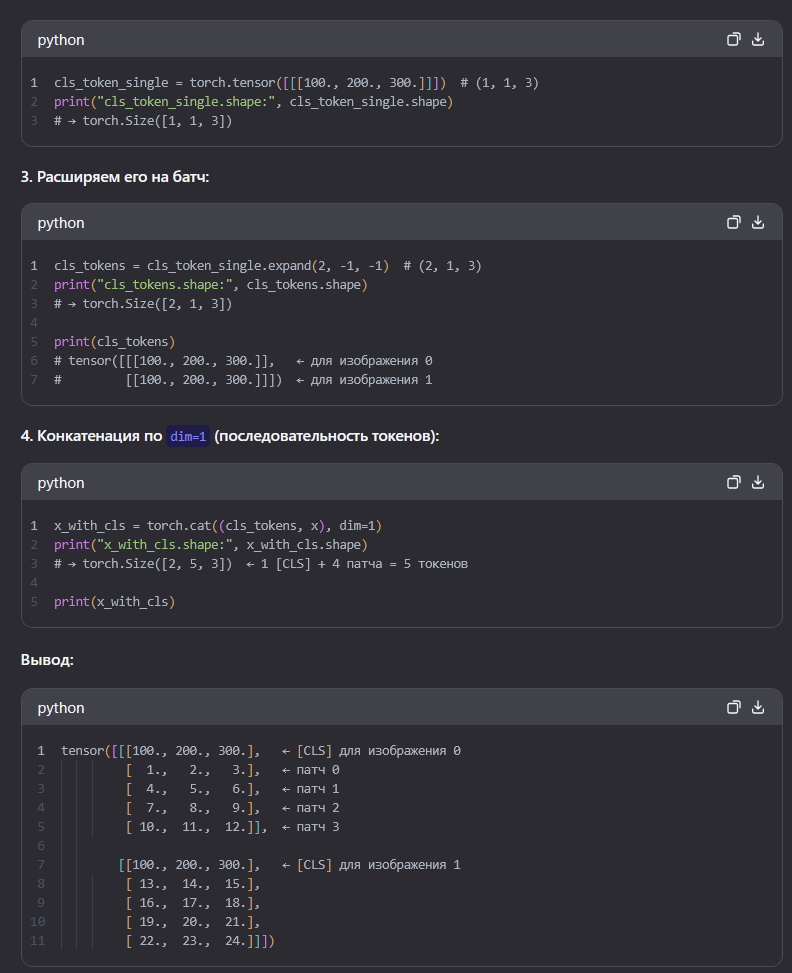

In [26]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features, out_features=in_features)
        self.dropout = nn.Dropout(p=drop_rate)
        
    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [27]:
class TransformerEncoderLayer(nn.Module):
        # Архитектура: Pre-LN (LayerNorm перед подмодулями)
    # ┌───────────────────────────────────────────────────────────────┐
    # │ x → LayerNorm → MultiheadAttention → Add (residual) →         │
    # │      ↑                                 │                      │
    # │      └─────────────────────────────────┘                      │
    # │                             ↓                                 │
    # │                      LayerNorm → MLP → Add (residual) → выход │
    # └───────────────────────────────────────────────────────────────┘
       
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()        
        self.norm1 = nn.LayerNorm(embed_dim)    # LayerNorm перед Attention | нормализует каждый токен по признакам (не по батчу!)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)     # Multi-Head Self-Attention (batch_first=True → (B, N, D) формат)
        self.norm2 = nn.LayerNorm(embed_dim)    # LayerNorm перед MLP
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)    # MLP: D → mlp_dim → D
        
    def forward(self, x):
        nx = self.norm1(x)
        x = x + self.attn(nx, nx, nx)[0]     # [0] — только output, без weights, возвращает (output, weights)
        x = x + self.mlp(self.norm2(x))    # MLP с residual connection
        
        return x    # (B, N, embed_dim) — форма сохраняется


In [28]:
# class VisionTransformer(nn.Module):
#     # Структура одного блока трансформера: x → LayerNorm → MultiHeadAttention → Add(x) → LayerNorm → MLP → Add(x) → выход
#     def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
#         super().__init__()
#         self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
#         self.encoder = nn.Sequential(*[
#             TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
#             for _ in range(depth)
#         ])
#         self.norm = nn.LayerNorm(embed_dim)
#         self.head = nn.Linear(embed_dim, num_classes)
        
#     def forward(self, x):
#         x = self.patch_embed(x)
#         x = self.encoder(x)
#         x = self.norm(x)
#         cls_token = x[:, 0]
        
#         return self.head(cls_token)
    

class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) — классификация изображений через Transformer.
    Структура: изображение → патчи → [CLS] + позиции → N×EncoderLayer → [CLS] → классы."""
    def __init__(
        self,
        img_size,        # int: размер входного изображения (H = W), например, 224
        patch_size,      # int: размер патча (P), например, 16
        in_channels,     # int: количество каналов (3 для RGB)
        num_classes,     # int: количество классов (10 для CIFAR-10)
        embed_dim,       # int: размерность эмбеддинга D, например, 768
        depth,           # int: количество EncoderLayer'ов, например, 12
        num_heads,       # int: количество голов внимания, например, 12
        mlp_dim,         # int: размер скрытого слоя в MLP, обычно 4×embed_dim → 3072
        drop_rate        # float: dropout rate, например, 0.1
    ):
        super().__init__()
        
        # 1. Преобразование изображения в последовательность токенов
        #    (B, ch, h, w) ---> (B, 1 + num_patches, embed_dim)
        self.patch_embed = PatchEmbedding(
            img_size, patch_size, in_channels, embed_dim
        )
        
        # 2. Стек из `depth` EncoderLayer'ов
        #    nn.Sequential(*) — распаковка списка слоёв
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)
        ])
        
        # 3. Финальная нормализация перед головой (по аналогии с BERT/ViT)
        self.norm = nn.LayerNorm(embed_dim)  # (B, N, D) → (B, N, D)
        
        # 4. Классификационная голова: только по [CLS] токену
        self.head = nn.Linear(embed_dim, num_classes)  # (B, D) → (B, num_classes)

    def forward(self, x):
        """
        Прямой проход ViT.
        
        Вход:
          x: torch.Tensor — изображения
             форма: (B, C, H, W)
             пример: (8, 3, 224, 224)
        
        Выход:
          logits: torch.Tensor — логиты классов (до softmax)
             форма: (B, num_classes)
             пример: (8, 1000) для ImageNet
        """
        # 1. Patch Embedding: изображение → токены
        #    (B, 3, 224, 224) → (B, 197, 768)  [196 патчей + 1 [CLS]]
        x = self.patch_embed(x)
        
        # 2. Transformer Encoder: глубокая обработка последовательности
        #    (B, 197, 768) → (B, 197, 768)
        x = self.encoder(x)
        
        # 3. Финальная нормализация (обычно есть в ViT)
        #    (B, 197, 768) → (B, 197, 768)
        x = self.norm(x)
        
        # 4. Берём только [CLS] токен (первый в последовательности)
        #    (B, 197, 768) → (B, 768)
        cls_token = x[:, 0]
        
        # 5. Классификация
        #    (B, 768) → (B, num_classes)
        return self.head(cls_token)

## Instantion model

In [29]:
model = VisionTransformer(
    image_size, patch_size, channels, num_classes, embed_dim,
    depth, num_heads, mlp_dim, drop_rate
).to(device)

model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

## Define loss function and optimizer